<a href="https://colab.research.google.com/github/akashapare/bosch-classification/blob/main/mobile_net_adam_lr_0_002_val_acc_0_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports and declerations

In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageFilter,ImageStat,ImageTransform, ImageOps,ImageShow
import random
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
#start = dt.datetime.now()

In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
INPUT_DIR = '/content/dataset'
#INPUT_DIR = '/content/drive/MyDrive/edge dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray_eq dataset'

In [3]:
BASE_SIZE =224 
NCATS = 5
tf.random.set_seed(1996)

In [4]:
EPOCHS = 15
size = 224
batchsize = 50

#model for colour images

NOTE:
this model is trained on top of previous weight improvement with 0.86 accuracy


In [5]:
model = MobileNet(input_shape=(size, size, 3), alpha=1., weights='/content/drive/MyDrive/color model .86 val acc plateau/weights-improvement-13-0.91.hdf5', classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC()])
print(model.summary())

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=0.3,)
validation_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='validation')
train_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='training')

Found 1026 images belonging to 5 classes.
Found 2403 images belonging to 5 classes.


In [11]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights= dict(enumerate(class_weights))
checkpoint_filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=True)
history=model.fit_generator(train_generator,
    steps_per_epoch = train_generator.samples // batchsize,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batchsize,
    epochs = EPOCHS,
    class_weight=class_weights,callbacks=[model_checkpoint_callback],workers=4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
48/48 [==============================] - 74s 1s/step - loss: 0.0910 - accuracy: 0.9584 - precision: 0.9595 - recall: 0.9567 - auc: 0.9959 - val_loss: 7.7465 - val_accuracy: 0.3540 - val_precision: 0.3544 - val_recall: 0.3530 - val_auc: 0.6222

Epoch 00001: val_accuracy improved from -inf to 0.35400, saving model to weights-improvement-01-0.35.hdf5
Epoch 2/15
48/48 [==============================] - 87s 2s/step - loss: 0.1123 - accuracy: 0.9460 - precision: 0.9495 - recall: 0.9422 - auc: 0.9933 - val_loss: 3.5841 - val_accuracy: 0.5490 - val_precision: 0.5510 - val_recall: 0.5460 - val_auc: 0.7850

Epoch 00002: val_accuracy improved from 0.35400 to 0.54900, saving model to weights-improvement-02-0.55.hdf5
Epoch 3/15
48/48 [==============================] - 75s 2s/step - loss: 0.0642 - accuracy: 0.9660 - precision: 0.9668 - recall: 0.9647 - auc: 0.9976 - val_loss: 0.6603 - val_accuracy: 0.8680 - val_precision: 0.8706 - val_recall: 0.8680 - val_auc: 0.9586

Epoch 00003: val_acc

In [12]:
print(history.history.keys())
np.save('history.npy',history.history)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


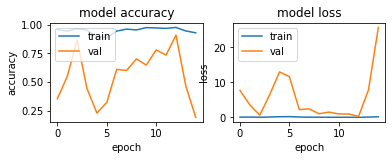

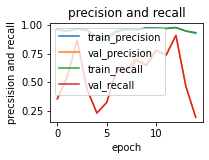

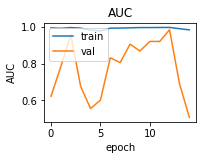

In [13]:
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
  
# summarize history for loss  
  
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  
# precision and recall
plt.subplot(223)  
plt.plot(history.history['precision'],'-')  
plt.plot(history.history['val_precision'],'-') 
plt.plot(history.history['recall'],'-')  
plt.plot(history.history['val_recall'],'-')  
plt.title('precision and recall')  
plt.ylabel('precsision and recall')  
plt.xlabel('epoch')  
plt.legend(['train_precision', 'val_precision','train_recall','val_recall'], loc='upper left')  
plt.show()  

#AUC
  
plt.subplot(224)  
plt.plot(history.history['auc'])  
plt.plot(history.history['val_auc'])  
plt.title('AUC')  
plt.ylabel('AUC')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [22]:
model.load_weights('/content/drive/MyDrive/color model .86 val acc plateau/weights-improvement-13-0.91.hdf5')

In [31]:
Y_pred=model.predict_generator(validation_generator,workers=4,verbose=1,steps=500)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


21/21 [==============================] - 18s 736ms/step


trial

In [41]:
#input=('/content/dataset/default/080721img41985.jpg')

img = image.load_img(input, target_size=(224, 224))
input = image.img_to_array(img)                           
input = input.reshape((1,) + input.shape)                   
input /= 255.0
np.argmax(model.predict(input))

0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


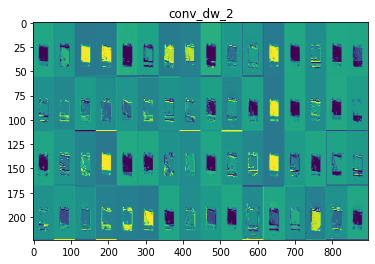

In [49]:
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(input) # Returns a list of five Numpy arrays: one array per layer activation


layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#model for grayscale/edge images

In [ ]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=5)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "mobilenet_1.00_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 256, 256, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 256, 256, 32

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
INPUT_DIR = '/content/drive/MyDrive/edge dataset'
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=0.3)
validation_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='grayscale',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='validation')
train_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='grayscale',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='training')

Found 1026 images belonging to 5 classes.
Found 2403 images belonging to 5 classes.


In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights= dict(enumerate(class_weights))
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.fit_generator(train_generator,
    steps_per_epoch = train_generator.samples // batchsize,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batchsize,
    epochs = EPOCHS,
    class_weight=class_weights,callbacks=[model_checkpoint_callback],workers=4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
48/48 [==============================] - 280s 5s/step - loss: 1.2515 - accuracy: 0.3519 - val_loss: 1.7718 - val_accuracy: 0.0700
Epoch 2/50
48/48 [==============================] - 105s 2s/step - loss: 0.8222 - accuracy: 0.5593 - val_loss: 1.6548 - val_accuracy: 0.0710
Epoch 3/50
48/48 [==============================] - 105s 2s/step - loss: 0.6363 - accuracy: 0.6634 - val_loss: 1.6313 - val_accuracy: 0.0710
Epoch 4/50
48/48 [==============================] - 103s 2s/step - loss: 0.5659 - accuracy: 0.6893 - val_loss: 1.5659 - val_accuracy: 0.6120
Epoch 5/50
48/48 [==============================] - 107s 2s/step - loss: 0.4855 - accuracy: 0.7556 - val_loss: 1.6424 - val_accuracy: 0.6120
Epoch 6/50
48/48 [==============================] - 106s 2s/step - loss: 0.4148 - accuracy: 0.7756 - val_loss: 1.5478 - val_accuracy: 0.6200
Epoch 7/50
48/48

In [ ]:
model.save('my_model_gray')

INFO:tensorflow:Assets written to: my_model_gray/assets
